In [1]:
import sys

import numpy as np
from matplotlib import pyplot as plt
import cv2
import time
import itertools
from scipy.ndimage import label
import warnings
from sklearn.metrics import precision_recall_curve, auc

from helpers import *
from gaussian_diffusion import GaussianDiffusionModel, get_beta_schedule
from unet import UNetModel
import data_loader
from anomaly_detection import *
import skimage.exposure

from torchvision import transforms
import random
import lpips
from torch.cuda.amp import autocast
import cv2

/home/camp/anaconda3/envs/diffusion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_synomaly_noise(x, synth_anomaly_masks, mode, anomaly_sigma=7, anomaly_threshold=150, anomaly_offset=0.5, anomaly_direction=1):
    
    noise = torch.zeros(x.shape)
    height, width = x.shape[2:4]

    for i in range(x.shape[0]):
        # create Gaussian background noise
        background_noise = np.random.randn(height, width)

        if mode == "inference":  # do not add synthetic anomalies in inference
            noise[i, 0] = torch.from_numpy(background_noise)

        else:
            # create a mask for shapes
            blur = cv2.GaussianBlur(background_noise, (0, 0), sigmaX=anomaly_sigma, sigmaY=anomaly_sigma, borderType=cv2.BORDER_DEFAULT)
            stretch = skimage.exposure.rescale_intensity(blur, in_range='image', out_range=(0, 255))
            shape_mask = cv2.threshold(stretch, anomaly_threshold, 1, cv2.THRESH_BINARY)[1]

            # crop the mask only to relevant area
            if synth_anomaly_masks is not None:
                synth_anomaly_mask = synth_anomaly_masks[i, 0].cpu().numpy()   # -1 regions not add synthetic anomaly, 1 regions add synthetic anomaly
                shape_mask[synth_anomaly_mask == -1] = 0

            # combine background noise and shape noise
            combined = background_noise.copy()

            combined[shape_mask == 1] += anomaly_direction * (torch.rand(1).item() + anomaly_offset)  # add or reduce 0.0-1.0 plus offset

            noise[i, 0] = torch.from_numpy(combined)

    return noise.to(x.device), shape_mask

In [3]:
def normalize_image(image, low, high):
    """
    Normalize the input image to the range [low, high].

    :param image: Input image as a NumPy array.
    :param low: The lower bound of the target range.
    :param high: The upper bound of the target range.

    :return: The normalized image as a NumPy array.
    """
    # Find the minimum and maximum pixel values in the image
    min_val = np.min(image)
    max_val = np.max(image)

    # Normalize the image to the range [low, high]
    normalized_image = (image - min_val) / (max_val - min_val) * (high - low) + low

    # Convert the image to the appropriate data type (uint8 for an image)
    normalized_image = normalized_image

    return normalized_image

-3.7010553 5.579257


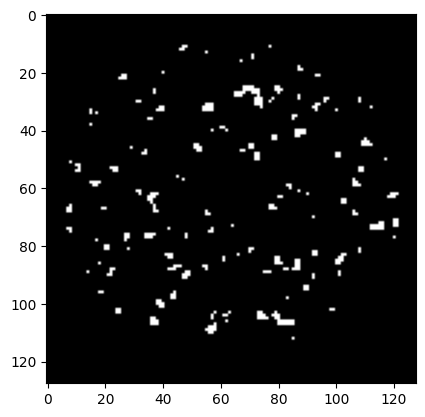

In [97]:
width = 128

x = torch.randn([1,1,width,width])


mode = 'training'
anomaly_sigma = 1
anomaly_threshold = 185
anomaly_offset = 1
anomaly_direction = 1

center_y, center_x = width // 2, width // 2

Y, X = np.ogrid[:width, :width]

dist_from_center = (X - center_x) ** 2 + (Y - center_y) ** 2

radius = width // 2.2

single_vessel_mask = (dist_from_center <= radius ** 2).astype(int)*2-1

synth_anomaly_masks = torch.from_numpy(single_vessel_mask).view(1,1,width,width)

# synth_anomaly_masks = None

noise, shape_mask = generate_synomaly_noise(x, synth_anomaly_masks, mode, anomaly_sigma, anomaly_threshold, anomaly_offset, anomaly_direction)

noise = noise.cpu().detach().numpy().squeeze()
print(noise.min(),noise.max())
noise = normalize_image(noise, 0, 255)
plt.imshow(shape_mask,cmap='gray')

In [5]:
def calculate_wadell_roundness(contour, image):
    """
    Calculate the Wadell roundness of a 2D shape given its contour.

    Parameters:
        contour (numpy.ndarray): Contour of the shape.
        image (numpy.ndarray): Original binary image containing the shapes.

    Returns:
        float: The Wadell roundness value.
    """
    # Create a mask for the contour
    mask = create_mask_for_contour(image, contour)

    # Get the largest inscribed circle radius
    max_radius = calculate_largest_inscribed_circle_radius(mask)

    # Approximate the shape with a polygon to find corners
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Calculate the curvature radii of the corners
    curvature_radii = []
    num_points = len(approx)

    for i in range(num_points):
        # Get three consecutive points (previous, current, next)
        prev_point = approx[i - 1][0]
        curr_point = approx[i][0]
        next_point = approx[(i + 1) % num_points][0]

        # Check if the segment is convex
        if is_convex(prev_point, curr_point, next_point):
            # Calculate the radius of the circle passing through these points
            curvature_radius = calculate_circle_radius(prev_point, curr_point, next_point)
            if curvature_radius is not None and curvature_radius <= max_radius:
                curvature_radii.append(curvature_radius)

    if not curvature_radii:
        raise ValueError("Could not calculate curvature radii.")

    # Visualize the approximated polygon on the image
#     visualize_polygon(image, approx)

    # Calculate Wadell roundness
    average_curvature_radius = np.mean(curvature_radii)
    wadell_roundness = average_curvature_radius / max_radius

    return wadell_roundness

def is_convex(prev_point, curr_point, next_point):
    """
    Check if the segment formed by three points is convex.

    Parameters:
        prev_point, curr_point, next_point (tuple): Points defining the segment.

    Returns:
        bool: True if the segment is convex, False otherwise.
    """
    # Convert points to numpy arrays
    prev_point, curr_point, next_point = np.array(prev_point), np.array(curr_point), np.array(next_point)

    # Compute vectors
    vector1 = curr_point - prev_point
    vector2 = next_point - curr_point

    # Calculate the cross product (z-component) to determine the sign of the angle
    cross_product = np.cross(vector1, vector2)

    # A positive cross product indicates a convex segment
    return cross_product > 0


def calculate_circle_radius(p1, p2, p3):
    """
    Calculate the radius of the circle passing through three points.

    Parameters:
        p1, p2, p3 (tuple): Coordinates of three points (x, y).

    Returns:
        float: The radius of the circle, or None if the points are collinear.
    """
    p1, p2, p3 = np.array(p1), np.array(p2), np.array(p3)

    # Calculate pairwise distances
    a = np.linalg.norm(p2 - p3)
    b = np.linalg.norm(p1 - p3)
    c = np.linalg.norm(p1 - p2)

    # Semi-perimeter
    s = (a + b + c) / 2

    # Area of the triangle using Heron's formula
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))

    if area == 0:
        return None  # Points are collinear

    # Circumcircle radius formula
    radius = (a * b * c) / (4 * area)
    return radius

def calculate_largest_inscribed_circle_radius(mask):
    """
    Calculate the radius of the largest inscribed circle for a given mask.

    Parameters:
        mask (numpy.ndarray): Binary mask of the shape.

    Returns:
        float: Radius of the largest inscribed circle.
    """
    # Create a distance transform of the binary mask
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    
    # Find the maximum distance value (this corresponds to the radius)
    max_radius = np.max(dist_transform)
    
    return max_radius

def extract_contours(image):
    """
    Extract contours from a binary image.

    Parameters:
        image (numpy.ndarray): Binary image of the shapes, where the shapes are white (255) and the background is black (0).

    Returns:
        list: List of contours found in the image.
    """
    # Ensure the image is binary
    if len(image.shape) != 2 or image.max() > 1:
        _, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return contours

def create_mask_for_contour(image, contour):
    """
    Create a binary mask for a given contour.

    Parameters:
        image (numpy.ndarray): Original binary image containing the shapes.
        contour (numpy.ndarray): Contour of the shape.

    Returns:
        numpy.ndarray: Binary mask for the given contour.
    """
    # Create an empty mask with the same dimensions as the input image
    mask = np.zeros(image.shape, dtype=np.uint8)
    
    # Draw the contour onto the mask
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    
    return mask

In [6]:
def calculate_convexity(contour):
    """
    Calculate the convexity (solidity) of a 2D shape given its contour.

    Parameters:
        contour (numpy.ndarray): Contour of the shape.

    Returns:
        float: The convexity (solidity) value.
    """
    # Area of the contour
    contour_area = cv2.contourArea(contour)

    # Area of the convex hull
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)

    if hull_area == 0:
        return 0

    # Calculate solidity
    solidity = contour_area / hull_area
    return solidity

In [7]:
def calculate_aspect_ratio(contour):
    """
    Calculate the aspect ratio of a 2D shape given its contour.

    Parameters:
        contour (numpy.ndarray): Contour of the shape.

    Returns:
        float: The aspect ratio value.
    """
    # Get the bounding rectangle of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Calculate aspect ratio
    aspect_ratio = float(w) / h if h != 0 else 0
    return aspect_ratio

In [8]:
def calculate_perimeter_sphericity(contour):
    """
    Calculate the perimeter sphericity of a 2D shape given its contour.

    Parameters:
        contour (numpy.ndarray): Contour of the shape.

    Returns:
        float: The perimeter sphericity value.
    """
    # Calculate the perimeter and area of the contour
    perimeter = cv2.arcLength(contour, True)
    area = cv2.contourArea(contour)

    if perimeter == 0:
        return 0

    # Calculate perimeter sphericity
    sphericity = (4 * np.pi * area) / (perimeter ** 2)
    return sphericity

In [9]:
def calculate_size(contour):
    """
    Calculate the size (area) of a 2D shape given its contour.

    Parameters:
        contour (numpy.ndarray): Contour of the shape.

    Returns:
        float: The size (area) of the shape.
    """
    # Calculate the area of the contour
    return cv2.contourArea(contour)

In [10]:
def visualize_shapes_with_numbers(image, contours):
    """
    Visualize the shapes in the image with bounding boxes and numbers using matplotlib.

    Parameters:
        image (numpy.ndarray): Original image where shapes are located.
        contours (list): List of contours found in the image.

    Returns:
        None
    """
    # Convert the grayscale image to RGB for visualization
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    for i, contour in enumerate(contours):
        # Get bounding box for each contour
        x, y, w, h = cv2.boundingRect(contour)

        # Draw the bounding box
        cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 1)

        # Put the shape number
        cv2.putText(output_image, str(i + 1), (x, y+10), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0, 0, 255), 1)

    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title("Shapes with Numbers")
    plt.axis("off")
    plt.show()

In [11]:
if shape_mask.max()<=1:
    shape_mask = (shape_mask*255).astype(np.uint8)
# print(shape_mask.max())
# Extract contours
contours = extract_contours(shape_mask)
contours = [contour for contour in contours if calculate_size(contour) >= size_threshold]

# Visualize the shapes with bounding boxes and numbers
visualize_shapes_with_numbers(shape_mask, contours)

# Calculate roundness for each contour
for i, contour in enumerate(contours):
    try:
        roundness = calculate_wadell_roundness(contour,shape_mask)
        convexity = calculate_convexity(contour)
        aspect_ratio = calculate_aspect_ratio(contour)
        perimeter_sphericity = calculate_perimeter_sphericity(contour)
        print(f"Shape {i + 1} Wadell Roundness: {roundness}")
        print(f"Shape {i + 1} Convexity (Solidity): {convexity}")
        print(f"Shape {i + 1} Aspect Ratio: {aspect_ratio}")
        print(f"Shape {i + 1} Perimeter Sphericity: {perimeter_sphericity}")
    except ValueError as e:
        print(f"Shape {i + 1} Error: {e}")

NameError: name 'size_threshold' is not defined

In [20]:
shape_mask.max()

255

In [74]:
x = torch.randn([1,1,128,128])
mode = 'training'
anomaly_sigma = 7
anomaly_threshold = 150
anomaly_offset = 1
anomaly_direction = 1

size_threshold = 10

num_list = []
size_list = []
roundness_list = []
convexity_list = []
aspect_ratio_list = []
perimeter_sphericity_list = []

break_outer_loop = False
for _ in range(1000):

    center_y, center_x = 128 // 2, 128 // 2

    Y, X = np.ogrid[:128, :128]

    dist_from_center = (X - center_x) ** 2 + (Y - center_y) ** 2

    radius = 128 // 2.2

    single_vessel_mask = (dist_from_center <= radius ** 2).astype(int)*2-1

    synth_anomaly_masks = torch.from_numpy(single_vessel_mask).view(1,1,128,128)

    # synth_anomaly_masks = None

    noise, shape_mask = generate_synomaly_noise(x, synth_anomaly_masks, mode, anomaly_sigma, anomaly_threshold, anomaly_offset, anomaly_direction)
    
    shape_mask = (shape_mask*255).astype(np.uint8)
    
    contours = extract_contours(shape_mask)
    
    filtered_contours = [contour for contour in contours if calculate_size(contour) >= size_threshold]
    
    num_list.append(len(filtered_contours))
    
    filtered_contours = sorted(filtered_contours, key=cv2.contourArea, reverse=True)
    
    for i, contour in enumerate(filtered_contours):
        try:
            if i > 2:
                continue
            roundness = calculate_wadell_roundness(contour, shape_mask)
            convexity = calculate_convexity(contour)
            aspect_ratio = calculate_aspect_ratio(contour)
            perimeter_sphericity = calculate_perimeter_sphericity(contour)
            
            roundness_list.append(roundness)
            convexity_list.append(convexity)
            aspect_ratio_list.append(aspect_ratio)
            perimeter_sphericity_list.append(perimeter_sphericity)
            size_list.append(cv2.contourArea(contour))
            
        except ValueError as e:
            continue
#             print(f"Shape {i + 1} Error: {e}")
#             break_outer_loop = True
#             break
#     if break_outer_loop:
#         break
    
    
    

In [75]:
print("number of contours", np.array(num_list).mean(), np.array(num_list).std())
print("roundness", np.array(roundness_list).mean(), np.array(roundness_list).std())
print("convexity", np.array(convexity_list).mean(), np.array(convexity_list).std())
print("aspect_ratio", np.array(aspect_ratio_list).mean(), np.array(aspect_ratio_list).std())
print("perimeter_sphericity", np.array(perimeter_sphericity_list).mean(), np.array(perimeter_sphericity_list).std())
print("size", np.array(size_list).mean(), np.array(size_list).std())

number of contours 4.884 1.9361156990221426
roundness 0.6782849761541381 0.18547074991751936
convexity 0.7939231112095394 0.15024758890085035
aspect_ratio 1.0722665167880874 0.42649958795235143
perimeter_sphericity 0.5019005124143796 0.22170702472680595
size 1293.206779661017 1689.3505944005506


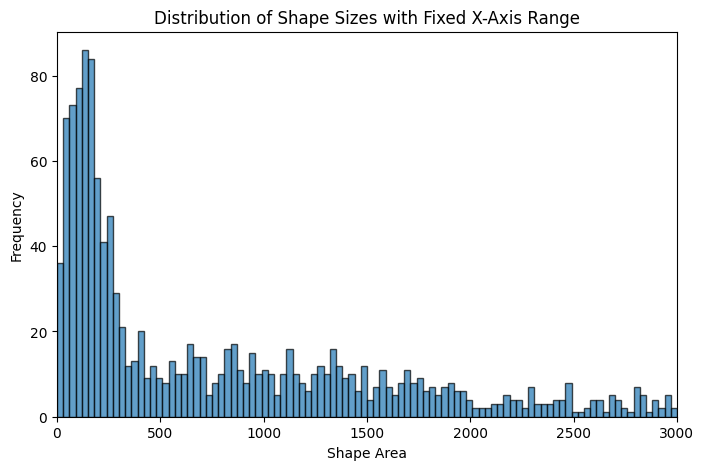

In [76]:
# Define the range and number of bins
num_bins = 100  # Change this to any number of bins you want
x_min, x_max = 0, 3000  # Define x-axis range

# Create bins with equal width within the specified range
bins = np.linspace(x_min, x_max, num_bins + 1)

# Create the histogram
plt.figure(figsize=(8, 5))
plt.hist(size_list, bins=bins, edgecolor='black', alpha=0.7)

# Set x-axis limits
plt.xlim(x_min, x_max)

# Labels and title
plt.xlabel("Shape Area")
plt.ylabel("Frequency")
plt.title("Distribution of Shape Sizes with Fixed X-Axis Range")

# Show the plot
plt.show()

In [34]:
print("number of contours", np.array(num_list).mean(), np.array(num_list).std())
print("roundness", np.array(roundness_list).mean(), np.array(roundness_list).std())
print("convexity", np.array(convexity_list).mean(), np.array(convexity_list).std())
print("aspect_ratio", np.array(aspect_ratio_list).mean(), np.array(aspect_ratio_list).std())
print("perimeter_sphericity", np.array(perimeter_sphericity_list).mean(), np.array(perimeter_sphericity_list).std())
print("size", np.array(size_list).mean(), np.array(size_list).std())

number of contours 4.807 1.9717380657683719
roundness 0.6799650399392596 0.18147294690948135
convexity 0.7963304472406766 0.14843718388219945
aspect_ratio 1.0597688134991956 0.4327912801364476
perimeter_sphericity 0.5014523443324844 0.22125575760580818
size 1341.102862849534 1764.921308898215


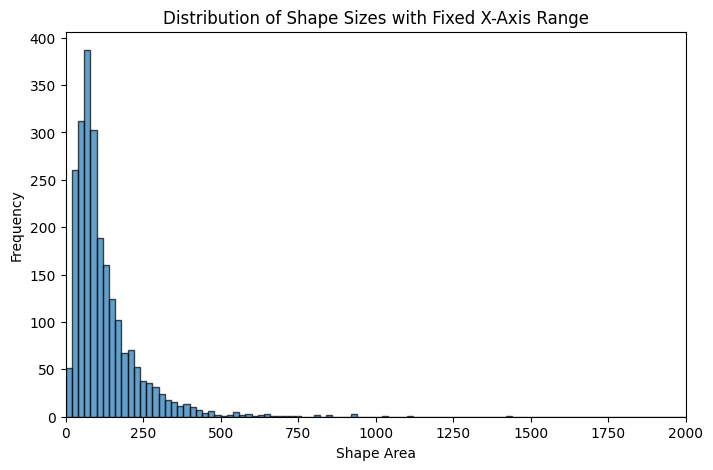

In [61]:
# Define the range and number of bins
num_bins = 100  # Change this to any number of bins you want
x_min, x_max = 0, 2000  # Define x-axis range

# Create bins with equal width within the specified range
bins = np.linspace(x_min, x_max, num_bins + 1)

# Create the histogram
plt.figure(figsize=(8, 5))
plt.hist(size_list, bins=bins, edgecolor='black', alpha=0.7)

# Set x-axis limits
plt.xlim(x_min, x_max)

# Labels and title
plt.xlabel("Shape Area")
plt.ylabel("Frequency")
plt.title("Distribution of Shape Sizes with Fixed X-Axis Range")

# Show the plot
plt.show()

In [78]:
brats_mask = np.load('../output/BraTS/test_anomalous_masks.npy')
brats_size_list = []
for m in brats_mask:
    m = cv2.resize(m,(128,128),cv2.INTER_NEAREST)
    brats_size_list.append(np.sum(m>0))
print(np.mean(brats_size_list))
print(np.mean(brats_size_list)*100/128**2)

575.875
3.514862060546875


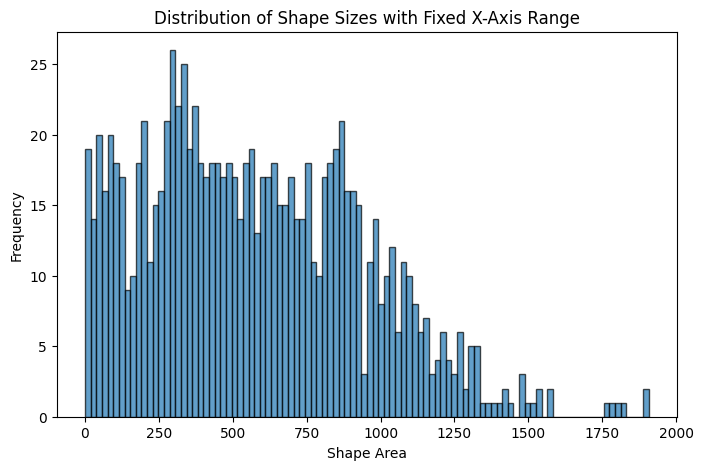

In [69]:
# Define the range and number of bins
num_bins = 100  # Change this to any number of bins you want
x_min, x_max = 0, 5000  # Define x-axis range

# Create bins with equal width within the specified range
bins = np.linspace(x_min, x_max, num_bins + 1)

# Create the histogram
plt.figure(figsize=(8, 5))
plt.hist(brats_size_list, bins=100, edgecolor='black', alpha=0.7)

# Set x-axis limits
# plt.xlim(x_min, x_max)

# Labels and title
plt.xlabel("Shape Area")
plt.ylabel("Frequency")
plt.title("Distribution of Shape Sizes with Fixed X-Axis Range")

# Show the plot
plt.show()

In [79]:
import pickle

# Load the pickle file
with open('../output/LiTS/test_anomalous_tumor_masks.pkl', "rb") as file:
    lits_mask = pickle.load(file)
lits_size_list = []
for m in lits_mask:
    m = cv2.resize(m,(128,128),cv2.INTER_NEAREST)
    lits_size_list.append(np.sum(m>0))
print(np.mean(lits_size_list))
print(np.mean(lits_size_list)*100/128**2)

388.096
2.36875


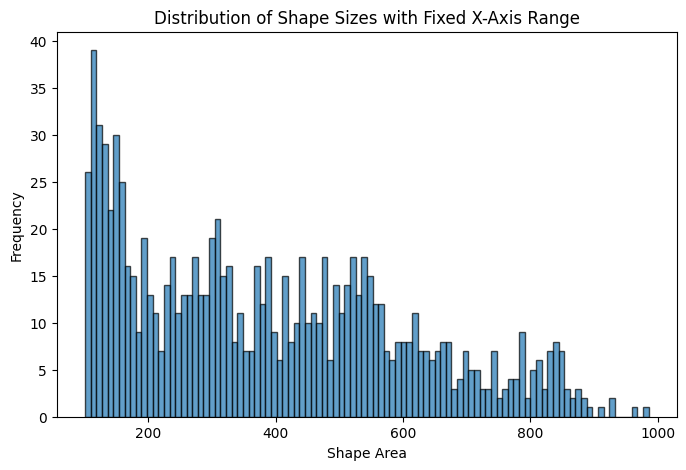

In [70]:
# Define the range and number of bins
num_bins = 100  # Change this to any number of bins you want
# Create bins with equal width within the specified range
bins = np.linspace(x_min, x_max, num_bins + 1)

# Create the histogram
plt.figure(figsize=(8, 5))
plt.hist(lits_size_list, bins=100, edgecolor='black', alpha=0.7)

# Set x-axis limits
# plt.xlim(x_min, x_max)

# Labels and title
plt.xlabel("Shape Area")
plt.ylabel("Frequency")
plt.title("Distribution of Shape Sizes with Fixed X-Axis Range")

# Show the plot
plt.show()

In [80]:
import pickle

# Load the pickle file
with open('../output/Ultrasound/test_anomalous_masks.pkl', "rb") as file:
    us_mask = pickle.load(file)
us_size_list = []
for m in us_mask:
    m = cv2.resize(m,(128,128),cv2.INTER_NEAREST)
    us_size_list.append(np.sum(m>0))
print(np.mean(us_size_list))
print(np.mean(us_size_list)*100/128**2)

1585.3394495412845
9.676144101204128


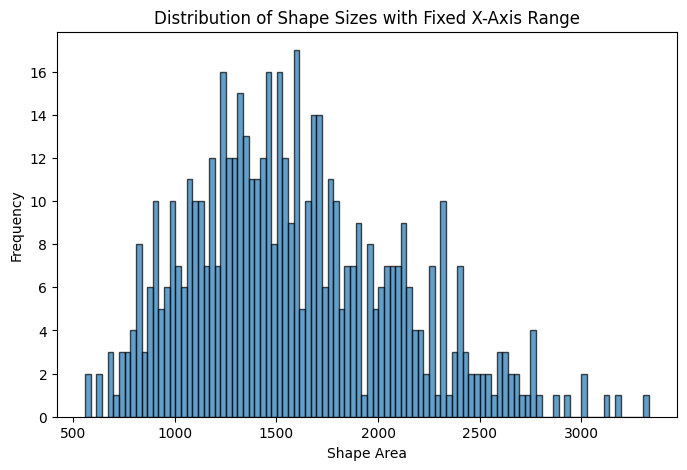

In [73]:
# Define the range and number of bins
num_bins = 100  # Change this to any number of bins you want
# Create bins with equal width within the specified range
bins = np.linspace(x_min, x_max, num_bins + 1)

# Create the histogram
plt.figure(figsize=(8, 5))
plt.hist(us_size_list, bins=100, edgecolor='black', alpha=0.7)

# Set x-axis limits
# plt.xlim(x_min, x_max)

# Labels and title
plt.xlabel("Shape Area")
plt.ylabel("Frequency")
plt.title("Distribution of Shape Sizes with Fixed X-Axis Range")

# Show the plot
plt.show()

In [77]:
1585/128**2

0.09674072265625

In [52]:
print("number of contours", np.array(num_list).mean(), np.array(num_list).std())
print("roundness", np.array(roundness_list).mean(), np.array(roundness_list).std())
print("convexity", np.array(convexity_list).mean(), np.array(convexity_list).std())
print("aspect_ratio", np.array(aspect_ratio_list).mean(), np.array(aspect_ratio_list).std())
print("perimeter_sphericity", np.array(perimeter_sphericity_list).mean(), np.array(perimeter_sphericity_list).std())
print("size", np.array(size_list).mean(), np.array(size_list).std())

number of contours 1.305 0.7784439607319207
roundness 0.9264889832013561 1.9025816935651478
convexity 0.8511946868122579 0.11319283804313106
aspect_ratio 1.0153008931218712 0.3114567692074807
perimeter_sphericity 0.49148248236716646 0.20389778390304095
size 6643.437088815789 3793.605158342008


In [58]:
print("number of contours", np.array(num_list).mean(), np.array(num_list).std())
print("roundness", np.array(roundness_list).mean(), np.array(roundness_list).std())
print("convexity", np.array(convexity_list).mean(), np.array(convexity_list).std())
print("aspect_ratio", np.array(aspect_ratio_list).mean(), np.array(aspect_ratio_list).std())
print("perimeter_sphericity", np.array(perimeter_sphericity_list).mean(), np.array(perimeter_sphericity_list).std())
print("size", np.array(size_list).mean(), np.array(size_list).std())

number of contours 2.457 1.1332038651540153
roundness 2.1350128119307197 2.1177004422683345
convexity 0.8251680595239935 0.128856041166247
aspect_ratio 1.14660818894708 0.6431347510878901
perimeter_sphericity 0.5110373552323708 0.176128776109758
size 1499.8269133299543 1868.7821634761392


In [64]:
print("number of contours", np.array(num_list).mean(), np.array(num_list).std())
print("roundness", np.array(roundness_list).mean(), np.array(roundness_list).std())
print("convexity", np.array(convexity_list).mean(), np.array(convexity_list).std())
print("aspect_ratio", np.array(aspect_ratio_list).mean(), np.array(aspect_ratio_list).std())
print("perimeter_sphericity", np.array(perimeter_sphericity_list).mean(), np.array(perimeter_sphericity_list).std())
print("size", np.array(size_list).mean(), np.array(size_list).std())

number of contours 34.903 10.026843521268296
roundness 1.2777437035985533 0.5155455367673257
convexity 0.553050251493047 0.17304548110415763
aspect_ratio 1.0822686027730641 0.44793979383196686
perimeter_sphericity 0.28809661829672817 0.1658658254867381
size 34.31242618889881 90.73013350209895


In [64]:
np.where(np.array(roundness_list)>1)

(array([  1,  20,  28,  36,  40,  49,  55,  57,  61,  71,  74,  87, 104,
        111, 117, 129, 171, 173, 194, 206, 207, 208, 216, 217, 225, 227,
        250, 273, 287, 288, 291, 293, 294, 309, 316, 319, 322, 340, 342,
        357, 377, 392, 425, 439, 455, 457, 470, 472, 474]),)

In [12]:
np.sqrt(10/np.pi)

1.7841241161527712

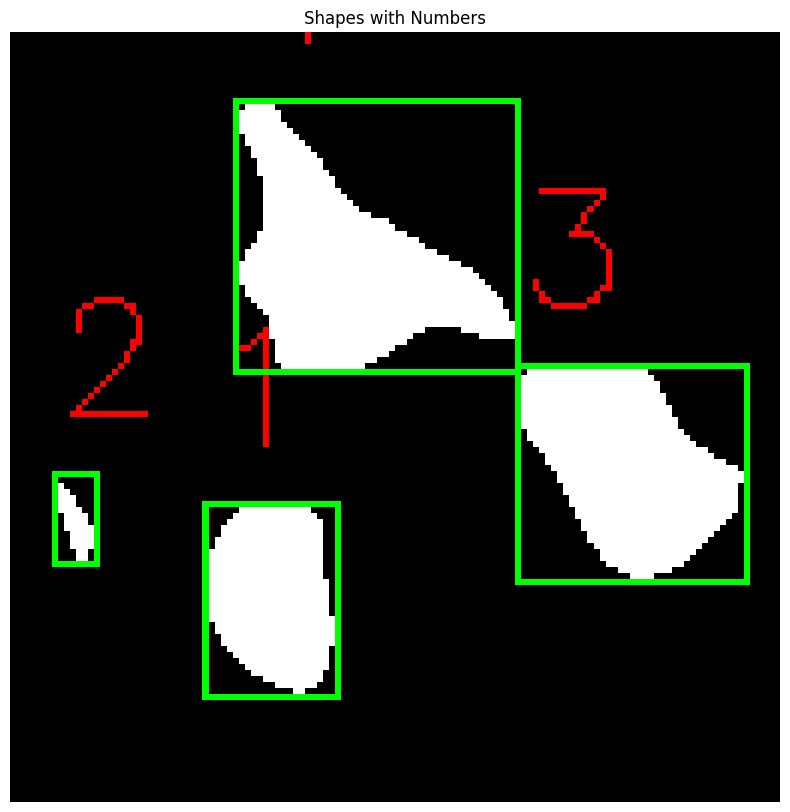

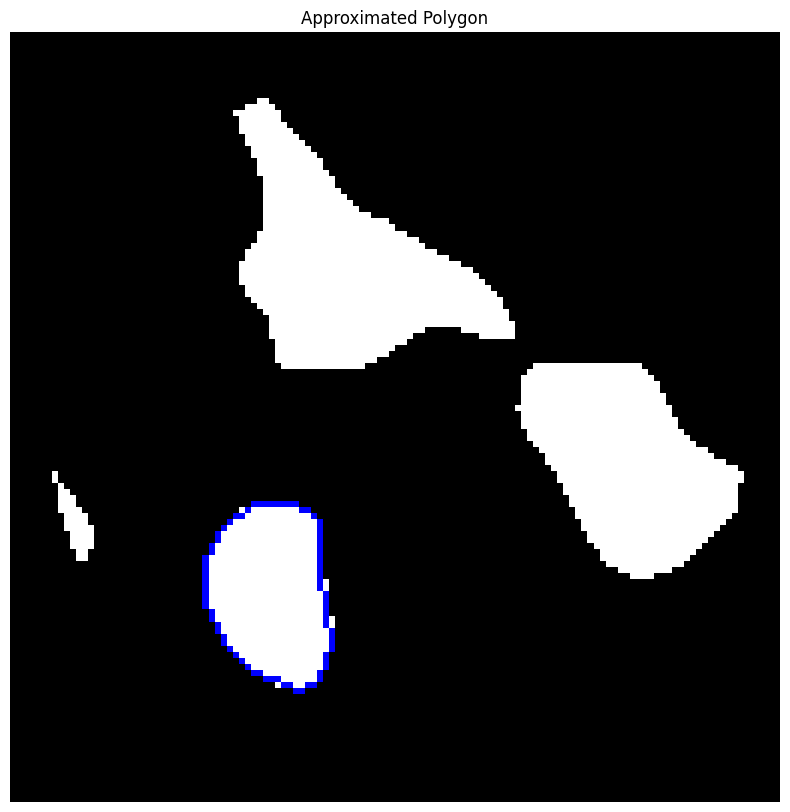

Shape 1 Wadell Roundness: 1.6017724362776473
Shape 1 Convexity (Solidity): 0.9648780487804878
Shape 1 Aspect Ratio: 0.6875
Shape 1 Perimeter Sphericity: 0.7990958599137701
Shape 1 Size (Area): 494.5


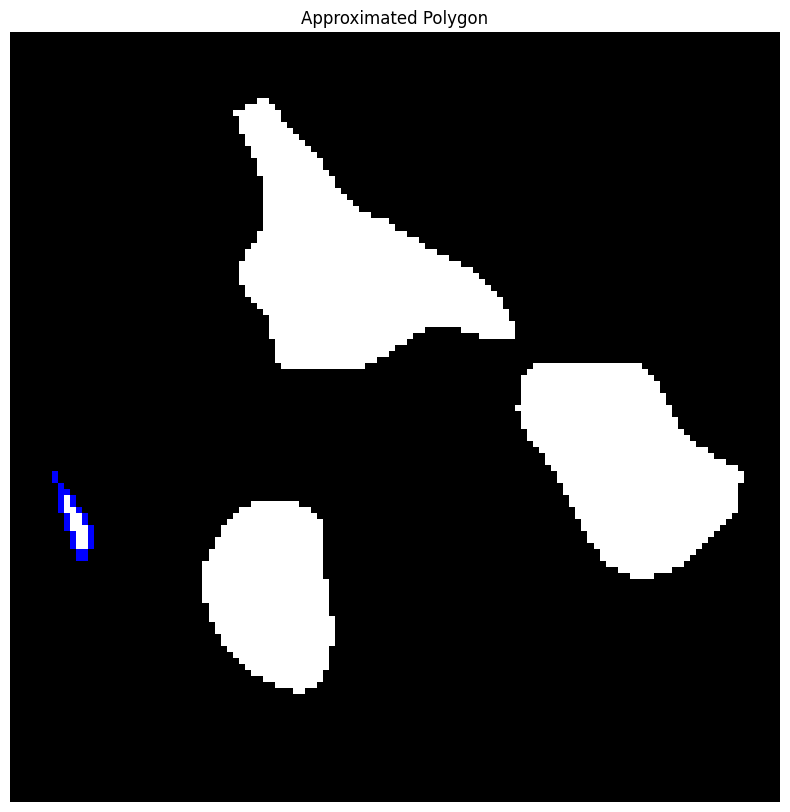

Shape 2 Wadell Roundness: 1.0594520724783676
Shape 2 Convexity (Solidity): 0.7808219178082192
Shape 2 Aspect Ratio: 0.4666666666666667
Shape 2 Perimeter Sphericity: 0.3180572678668895
Shape 2 Size (Area): 28.5


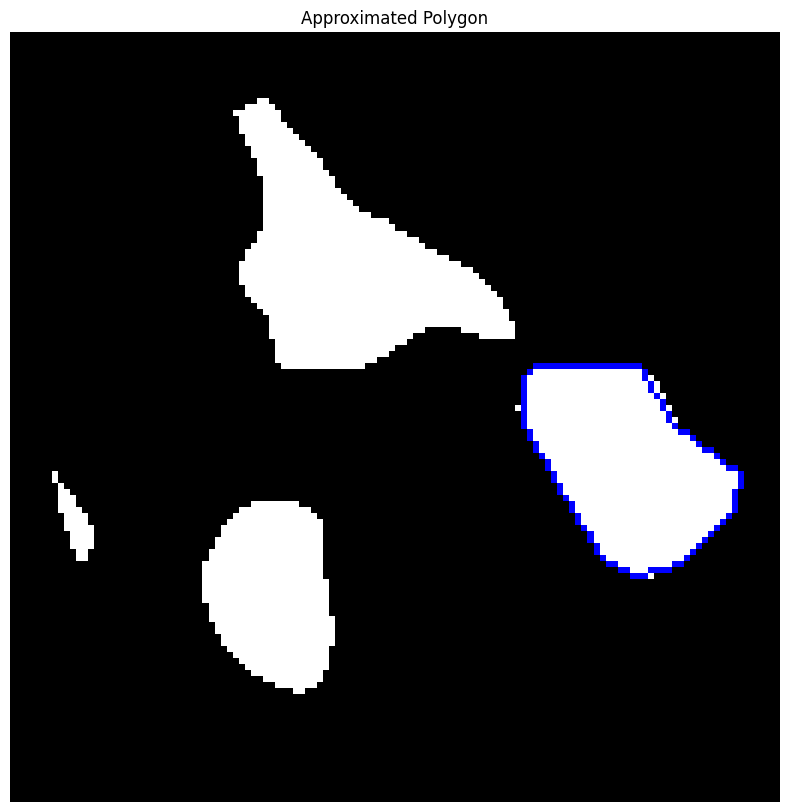

Shape 3 Wadell Roundness: 1.5462199153529188
Shape 3 Convexity (Solidity): 0.937021777516186
Shape 3 Aspect Ratio: 1.0555555555555556
Shape 3 Perimeter Sphericity: 0.7300485220817835
Shape 3 Size (Area): 796.0


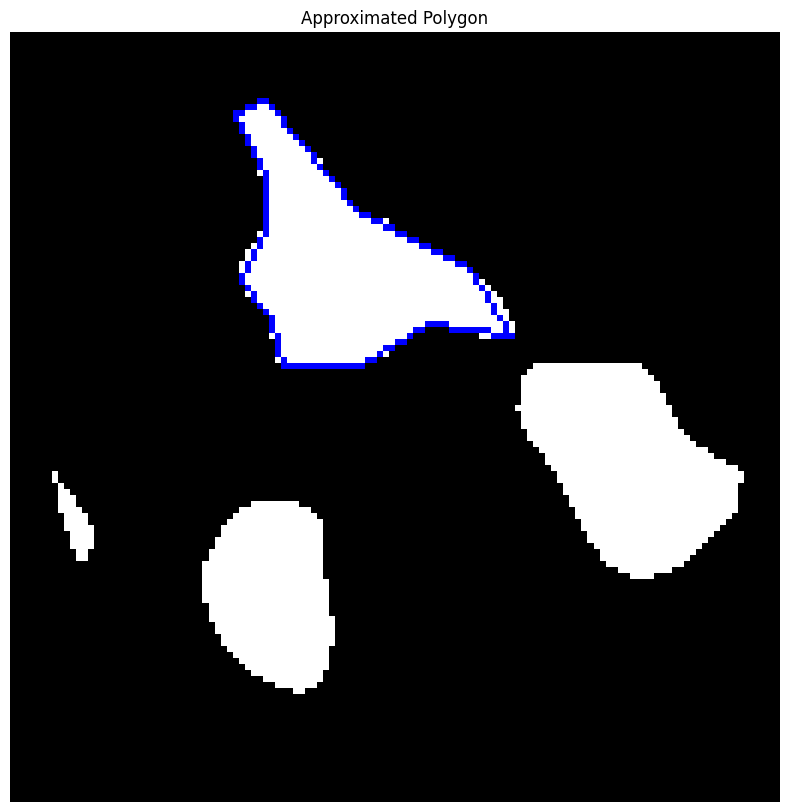

Shape 4 Wadell Roundness: 1.5288188890836951
Shape 4 Convexity (Solidity): 0.7908055672711936
Shape 4 Aspect Ratio: 1.0444444444444445
Shape 4 Perimeter Sphericity: 0.47529003139133313
Shape 4 Size (Area): 937.5


In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_wadell_roundness(contour, image):
    """
    Calculate the Wadell roundness of a 2D shape given its contour.

    Parameters:
        contour (numpy.ndarray): Contour of the shape.
        image (numpy.ndarray): Original binary image containing the shapes.

    Returns:
        float: The Wadell roundness value.
    """
    # Create a mask for the contour
    mask = create_mask_for_contour(image, contour)

    # Get the largest inscribed circle radius
    max_radius = calculate_largest_inscribed_circle_radius(mask)

    # Approximate the shape with a polygon to find corners
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Calculate the curvature radii of the corners
    curvature_radii = []
    num_points = len(approx)

    for i in range(num_points):
        # Get three consecutive points (previous, current, next)
        prev_point = approx[i - 1][0]
        curr_point = approx[i][0]
        next_point = approx[(i + 1) % num_points][0]

        # Calculate the radius of the circle passing through these points
        curvature_radius = calculate_circle_radius(prev_point, curr_point, next_point)
        if curvature_radius is not None:
            curvature_radii.append(curvature_radius)

    if not curvature_radii:
        raise ValueError("Could not calculate curvature radii.")

    # Visualize the approximated polygon on the image
    visualize_polygon(image, approx)

    # Calculate Wadell roundness
    average_curvature_radius = np.mean(curvature_radii)
    wadell_roundness = average_curvature_radius / max_radius

    return wadell_roundness

def visualize_polygon(image, polygon):
    """
    Visualize the approximated polygon on the image.

    Parameters:
        image (numpy.ndarray): Original binary image containing the shapes.
        polygon (numpy.ndarray): Approximated polygon points.

    Returns:
        None
    """
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.polylines(output_image, [polygon], isClosed=True, color=(255, 0, 0), thickness=1)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title("Approximated Polygon")
    plt.axis("off")
    plt.show()

def calculate_largest_inscribed_circle_radius(mask):
    """
    Calculate the radius of the largest inscribed circle for a given mask.

    Parameters:
        mask (numpy.ndarray): Binary mask of the shape.

    Returns:
        float: Radius of the largest inscribed circle.
    """
    # Create a distance transform of the binary mask
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    
    # Find the maximum distance value (this corresponds to the radius)
    max_radius = np.max(dist_transform)
    
    return max_radius

def calculate_circle_radius(p1, p2, p3):
    """
    Calculate the radius of the circle passing through three points.

    Parameters:
        p1, p2, p3 (tuple): Coordinates of three points (x, y).

    Returns:
        float: The radius of the circle, or None if the points are collinear.
    """
    p1, p2, p3 = np.array(p1), np.array(p2), np.array(p3)

    # Calculate pairwise distances
    a = np.linalg.norm(p2 - p3)
    b = np.linalg.norm(p1 - p3)
    c = np.linalg.norm(p1 - p2)

    # Semi-perimeter
    s = (a + b + c) / 2

    # Area of the triangle using Heron's formula
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))

    if area == 0:
        return None  # Points are collinear

    # Circumcircle radius formula
    radius = (a * b * c) / (4 * area)
    return radius

def calculate_convexity(contour):
    """
    Calculate the convexity (solidity) of a 2D shape given its contour.

    Parameters:
        contour (numpy.ndarray): Contour of the shape.

    Returns:
        float: The convexity (solidity) value.
    """
    # Area of the contour
    contour_area = cv2.contourArea(contour)

    # Area of the convex hull
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)

    if hull_area == 0:
        return 0

    # Calculate solidity
    solidity = contour_area / hull_area
    return solidity

def calculate_aspect_ratio(contour):
    """
    Calculate the aspect ratio of a 2D shape given its contour.

    Parameters:
        contour (numpy.ndarray): Contour of the shape.

    Returns:
        float: The aspect ratio value.
    """
    # Get the bounding rectangle of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Calculate aspect ratio
    aspect_ratio = float(w) / h if h != 0 else 0
    return aspect_ratio

def calculate_perimeter_sphericity(contour):
    """
    Calculate the perimeter sphericity of a 2D shape given its contour.

    Parameters:
        contour (numpy.ndarray): Contour of the shape.

    Returns:
        float: The perimeter sphericity value.
    """
    # Calculate the perimeter and area of the contour
    perimeter = cv2.arcLength(contour, True)
    area = cv2.contourArea(contour)

    if perimeter == 0:
        return 0

    # Calculate perimeter sphericity
    sphericity = (4 * np.pi * area) / (perimeter ** 2)
    return sphericity

def calculate_size(contour):
    """
    Calculate the size (area) of a 2D shape given its contour.

    Parameters:
        contour (numpy.ndarray): Contour of the shape.

    Returns:
        float: The size (area) of the shape.
    """
    # Calculate the area of the contour
    return cv2.contourArea(contour)

def create_mask_for_contour(image, contour):
    """
    Create a binary mask for a given contour.

    Parameters:
        image (numpy.ndarray): Original binary image containing the shapes.
        contour (numpy.ndarray): Contour of the shape.

    Returns:
        numpy.ndarray: Binary mask for the given contour.
    """
    # Create an empty mask with the same dimensions as the input image
    mask = np.zeros(image.shape, dtype=np.uint8)
    
    # Draw the contour onto the mask
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    
    return mask

def extract_contours(image):
    """
    Extract contours from a binary image.

    Parameters:
        image (numpy.ndarray): Binary image of the shapes, where the shapes are white (255) and the background is black (0).

    Returns:
        list: List of contours found in the image.
    """
    # Ensure the image is binary
    if len(image.shape) != 2 or image.max() > 1:
        _, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return contours

def visualize_shapes_with_numbers(image, contours):
    """
    Visualize the shapes in the image with bounding boxes and numbers using matplotlib.

    Parameters:
        image (numpy.ndarray): Original image where shapes are located.
        contours (list): List of contours found in the image.

    Returns:
        None
    """
    # Convert the grayscale image to RGB for visualization
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    for i, contour in enumerate(contours):
        # Get bounding box for each contour
        x, y, w, h = cv2.boundingRect(contour)

        # Draw the bounding box
        cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 1)

        # Put the shape number
        cv2.putText(output_image, str(i + 1), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 1)

    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title("Shapes with Numbers")
    plt.axis("off")
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Create a binary image with multiple shapes
    if shape_mask.max()<=1:
        shape_mask = (shape_mask*255).astype(np.uint8)
    # Extract contours
    contours = extract_contours(shape_mask)

    # Visualize the shapes with bounding boxes and numbers
    visualize_shapes_with_numbers(shape_mask, contours)

    # Calculate metrics for each contour
    for i, contour in enumerate(contours):
        try:
            roundness = calculate_wadell_roundness(contour, shape_mask)
            convexity = calculate_convexity(contour)
            aspect_ratio = calculate_aspect_ratio(contour)
            perimeter_sphericity = calculate_perimeter_sphericity(contour)
            size = calculate_size(contour)
            print(f"Shape {i + 1} Wadell Roundness: {roundness}")
            print(f"Shape {i + 1} Convexity (Solidity): {convexity}")
            print(f"Shape {i + 1} Aspect Ratio: {aspect_ratio}")
            print(f"Shape {i + 1} Perimeter Sphericity: {perimeter_sphericity}")
            print(f"Shape {i + 1} Size (Area): {size}")
        except ValueError as e:
            print(f"Shape {i + 1} Error: {e}")
